In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler
import gseapy as gp

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [14]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
GS_FILE=DATA_PATH+'/gs_file/magma_10kb_1000.gs'
TRAIT_INFO_FILE=DATA_PATH+'/supp_table/trait_info.tsv'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_hep'

# Data set info
DS_LIST = ['facs', 'aizarani']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
# DIC_INFO['droplet'] = {'species': 'mmusculus', 'dname': 'TMS Droplet'}
DIC_INFO['aizarani'] = {'species': 'hsapiens', 'dname': 'Human liver'}
# DIC_INFO['halpern'] = {'species': 'mmusculus', 'dname': 'Mouse liver'}

# Set score files
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_1000',
                  'facs.hm': DATA_PATH+'/score_file/score.tms_facs_with_cov.hep_metabolic',
#                   'droplet': DATA_PATH+'/score_file/score.tms_droplet_with_cov.gwas_max_abs_z.top500',
                  'aizarani': DATA_PATH+'/score_file/score.liver_atlas_with_cov.magma_10kb_1000',
                  'aizarani.hm': DATA_PATH+'/score_file/score.liver_atlas_with_cov.hep_metabolic',
#                   'halpern': DATA_PATH+'/score_file/score.mouse_liver_halpern_full.magma_10kb_1000'
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['facs'] = ['UKB_460K.biochemistry_AlanineAminotransferase',
                             'UKB_460K.biochemistry_AlkalinePhosphatase',
                             'UKB_460K.biochemistry_Cholesterol',
                             'UKB_460K.biochemistry_HDLcholesterol',
                             'UKB_460K.biochemistry_LDLdirect',
                             'UKB_460K.biochemistry_SHBG',
                             'UKB_460K.biochemistry_Testosterone_Male',
                             'UKB_460K.biochemistry_TotalBilirubin',
                             'UKB_460K.biochemistry_Triglycerides']
DIC_TRAIT_LIST['facs.hm'] = ['Beta-oxidation', 'Cholesterol biosynthesis', 'Glycolysis', 'Protein secretion',
                              'Bile acid production', 'Gluconeogenesis', 'Lipogenesis', 'Xenobiotic metabolism']
DIC_TRAIT_LIST['aizarani'] = DIC_TRAIT_LIST['facs'].copy()
DIC_TRAIT_LIST['aizarani.hm'] = DIC_TRAIT_LIST['facs.hm'].copy()
DIC_TRAIT_LIST['halpern'] = DIC_TRAIT_LIST['facs'].copy()

# Set trait info
DF_TRAIT_INFO = pd.read_csv(TRAIT_INFO_FILE, sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
for trait in DF_TRAIT_INFO.index[DF_TRAIT_INFO['Code'].isna()]:
    trait_short = trait.replace('PASS_','').replace('UKB_460K.','')
    trait_short = trait_short.replace('blood_','').replace('disease_','')
    DF_TRAIT_INFO.loc[trait, 'Code'] = trait_short

### Load data 

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
# dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')
dic_data_raw['aizarani'] = dl.load_aizarani_raw_data(opt='raw')
# dic_data_raw['halpern'] = dl.load_halpern_shenhav_raw_data(opt='raw')

dic_data_proc = {}
dic_data_proc['facs'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                                  'hep.facs.h5ad')
# dic_data_proc['droplet'] = dl.load_tms_processed(DATA_PATH, data_name='droplet', tissue='Liver')['Liver']
# dic_data_proc['aizarani'] = dl.load_aizarani_raw_data(opt='processed')
dic_data_proc['aizarani'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/'
                                      'tms_proc/hep.aizarani.h5ad')
# dic_data_proc['halpern'] = dl.load_halpern_shenhav_raw_data(opt='processed')

# Add mt_prop to facs fata
temp_adata = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/tabula_muris_senis/'
                       'adata_genecode_counts_for_gatk_with_metadata.h5ad')
mt_list = [x for x in temp_adata.var_names if x.startswith('mt-')]
temp_adata.obs['mt_prop'] = temp_adata[:, mt_list].X.sum(axis=1) / temp_adata.X.sum(axis=1)

df_mt = pd.DataFrame(index=dic_data_proc['facs'].obs['cell'])
temp_df = temp_adata.obs.copy()
temp_df.index = temp_df['cell']
df_mt = df_mt.join(temp_df['mt_prop'])
dic_data_proc['facs'].obs['mt_prop'] = df_mt['mt_prop'].values

Trying to set attribute `.obs` of view, copying.
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)        

# Cell list to analyze
dic_cell_list = {}
for score in DIC_SCORE_PATH:
    ds = score.replace('.hm','')
    dic_cell_list[score] = list(set(dic_data_proc[ds].obs_names) & set(dic_score[score].index))

In [5]:
# # Compute correlation between n_gene and score 
# dic_data_raw['aizarani'].obs['n_genes'] = (dic_data_raw['aizarani'].X>0).sum(axis=1)
# df_plot = dic_data_raw['aizarani'].obs[['n_genes']]
# df_plot = df_plot.join(dic_score['aizarani'])
# df_plot = df_plot.loc[df_plot.isna().sum(axis=1)==0]
# for trait in DIC_TRAIT_LIST['aizarani']:
#     print('# %-30s    corr=%0.3f'%(trait, np.corrcoef(df_plot['n_genes'], df_plot['%s.norm_score'%trait])[0,1]))

In [6]:
# Load control score 
dic_ctrl_score = {}
for score in DIC_SCORE_PATH:
# for score in ['aizarani.hm']:
    ds = score.split('.')[0]
    dic_ctrl_score[score] = {}
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.full_score.gz'%trait)
        if os.path.exists(file_path):
            print('# Loading %s %s'%(score, trait))
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df = temp_df.loc[set(dic_data_proc[ds].obs_names) & set(temp_df.index)]
            dic_ctrl_score[score][trait] = temp_df.copy()
        else:
            print('# missing: %s'%file_path)
        dic_ctrl_score[score][trait] = dic_ctrl_score[score][trait].loc[dic_cell_list[score]].copy()

# Loading aizarani.hm Beta-oxidation
# Loading aizarani.hm Cholesterol biosynthesis
# Loading aizarani.hm Glycolysis
# Loading aizarani.hm Protein secretion
# Loading aizarani.hm Bile acid production
# Loading aizarani.hm Gluconeogenesis
# Loading aizarani.hm Lipogenesis
# Loading aizarani.hm Xenobiotic metabolism


### UMAP for all hepatocytes

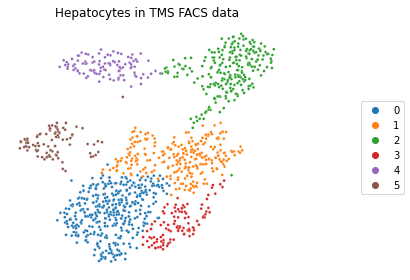

In [7]:
# Figure 
df_plot = pd.DataFrame(index=dic_data_proc['facs'].obs_names,
                       data={'UMAP1':dic_data_proc['facs'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc['facs'].obsm['X_umap'][:,1]})
df_plot = df_plot.join(dic_data_proc['facs'].obs['leiden'])

plt.figure(figsize=[6,4])
ax = plt.subplot(1,1,1)
ax.axis('off')
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='leiden', s=8)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.title('Hepatocytes in TMS FACS data')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/hep_tms_annot_umap.svg')
# plt.savefig(FIG_PATH+'/hep_tms_annot_umap.png')
plt.show()

### Subpolulation of associated cells 

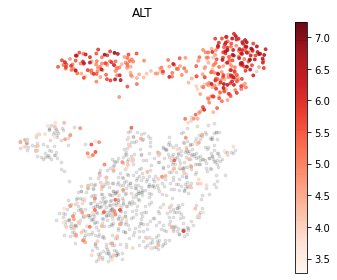

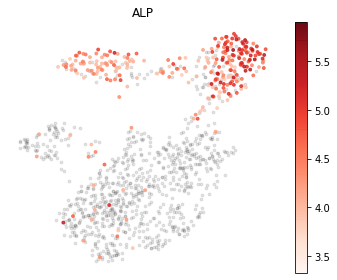

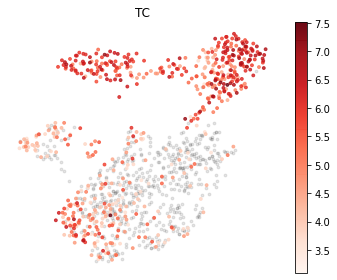

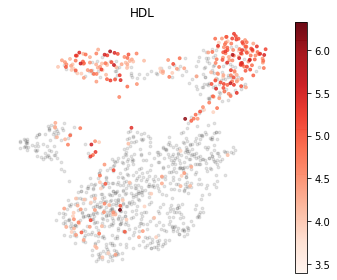

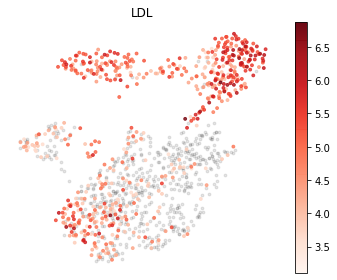

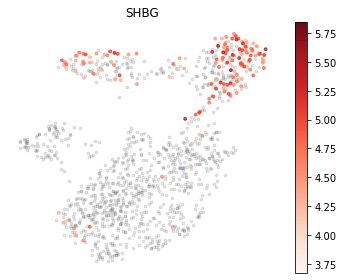

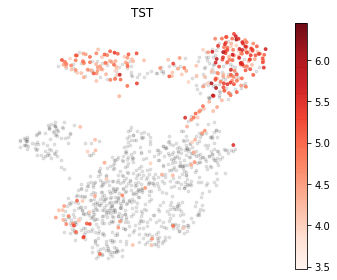

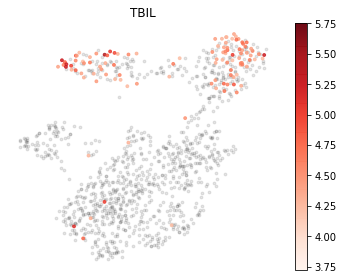

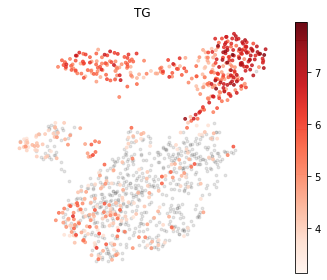

In [15]:
ds = 'facs'
for trait in DIC_TRAIT_LIST[ds]:
        
    plt.figure(figsize=[5,4])
    ax = plt.subplot(1,1,1)
    ax.axis('off')
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
                                 'leiden_anno':dic_data_proc[ds].obs['leiden']})
    df_plot = df_plot.loc[dic_cell_list[ds]]
    df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
    df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

    ind_select = df_plot['%s.fdr'%trait]<0.1
    vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
    vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
    plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                c='k', s=8, alpha=0.1)
    plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                c=df_plot.loc[ind_select, '%s.norm_score'%trait],
                cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
    plt.colorbar()
    plt.title(DF_TRAIT_INFO.loc[trait, 'Code'])

    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(ds, trait))
    plt.show()
#     break

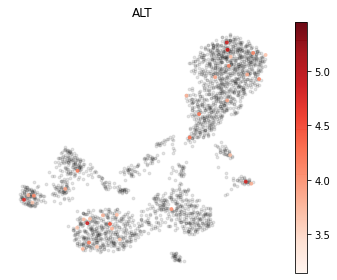

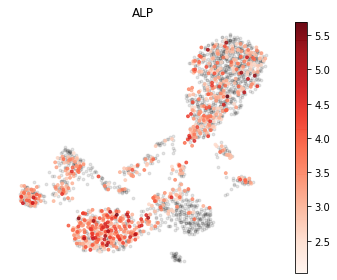

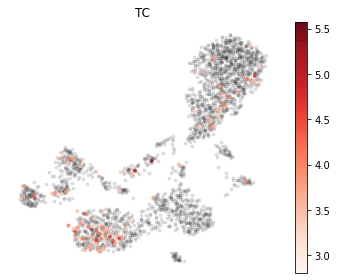

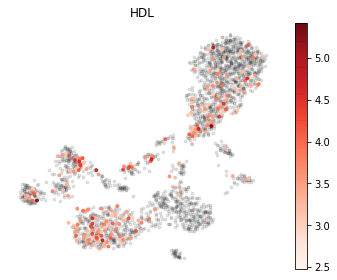

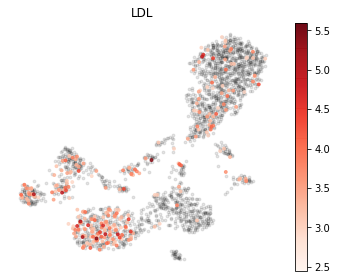

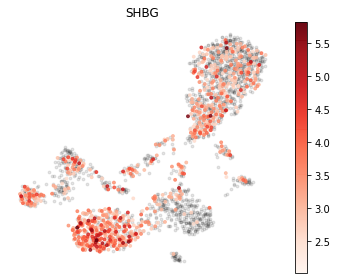

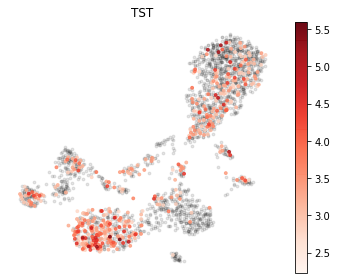

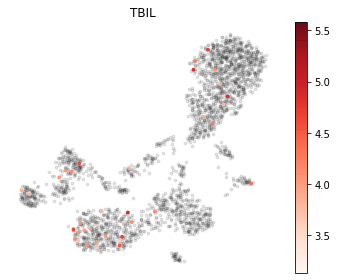

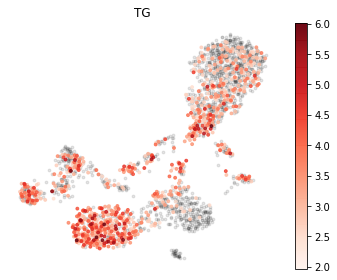

In [16]:
for ds in ['aizarani']:
    for trait in DIC_TRAIT_LIST[ds]:
        
        plt.figure(figsize=[5,4])
        ax = plt.subplot(1,1,1)
        ax.axis('off')
        df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                               data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                     'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1], 
                                     'leiden_anno':dic_data_proc[ds].obs['leiden']})
        df_plot = df_plot.loc[dic_cell_list[ds]]
        df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
        df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

        ind_select = df_plot['%s.fdr'%trait]<0.1
        vmax = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.99) + 0.5
        vmin = np.quantile(df_plot.loc[ind_select, '%s.norm_score'%trait], 0.01) - 0.5
        plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                    c='k', s=8, alpha=0.1)
        plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], 
                    c=df_plot.loc[ind_select, '%s.norm_score'%trait],
                    cmap='Reds', s=8, vmax=vmax, vmin=vmin, alpha=0.8)
        plt.colorbar()
        plt.title(DF_TRAIT_INFO.loc[trait, 'Code'])

        plt.tight_layout()
    #     plt.savefig(FIG_PATH+'/sctrs_assoc.%s.%s.svg'%(ds, trait))
        plt.show()

In [19]:
dic_data_proc['aizarani']

AnnData object with n_obs × n_vars = 2497 × 10254
    obs: 'cluster_id', 'cell_id', 'celltype', 'n_counts', 'zonation', 'n_genes', 'patient', 'batch_harmony', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'patient_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [21]:
# dic_data_raw['aizarani'].obs['n_genes'] = (dic_data_raw['aizarani'].X>0).sum(axis=1)
# # dic_data_proc['aizarani'].obs = dic_data_proc['aizarani'].obs.join(dic_data_raw['aizarani'].obs[['n_genes']])

# marker_list = ['GLUL', 'CYP2E1', 'ALB', 'n_genes', 'LDLR']
# sc.pl.umap(dic_data_proc['aizarani'], color=marker_list)

# adata = dic_data_proc['aizarani'][dic_data_proc['aizarani'].obs['celltype']=='hepatocytes',:].copy()
# adata.obs = adata.obs.join(dic_score['aizarani']['%s.fdr'%trait])
# adata.obs['leiden_sig'] = ['%s.sig'%x if y<0.1 else 'nonsig'
#                            for x,y in zip(adata.obs['leiden'], adata.obs['%s.fdr'%trait])]
# marker_list = ['VLDLR', 'LDLR', 'LRP1', 'SCARB1', 'SREBF2', 'SCAP', 'PCSK9', 'SAR1B', 'ITGAV']
# for gene in marker_list.copy():
#     if gene not in adata.var_names:
#         marker_list.remove(gene)
#         print('# Removed: %s'%gene)
# sc.pl.dotplot(adata, marker_list, groupby='leiden_sig')

### Annotation for LDL associated cells 

... storing 'tissue_celltype' as categorical
... storing 'leiden_sig' as categorical
... storing 'leiden_hq' as categorical


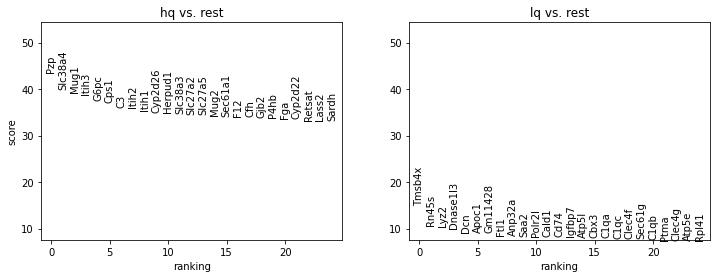

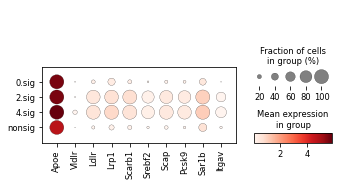

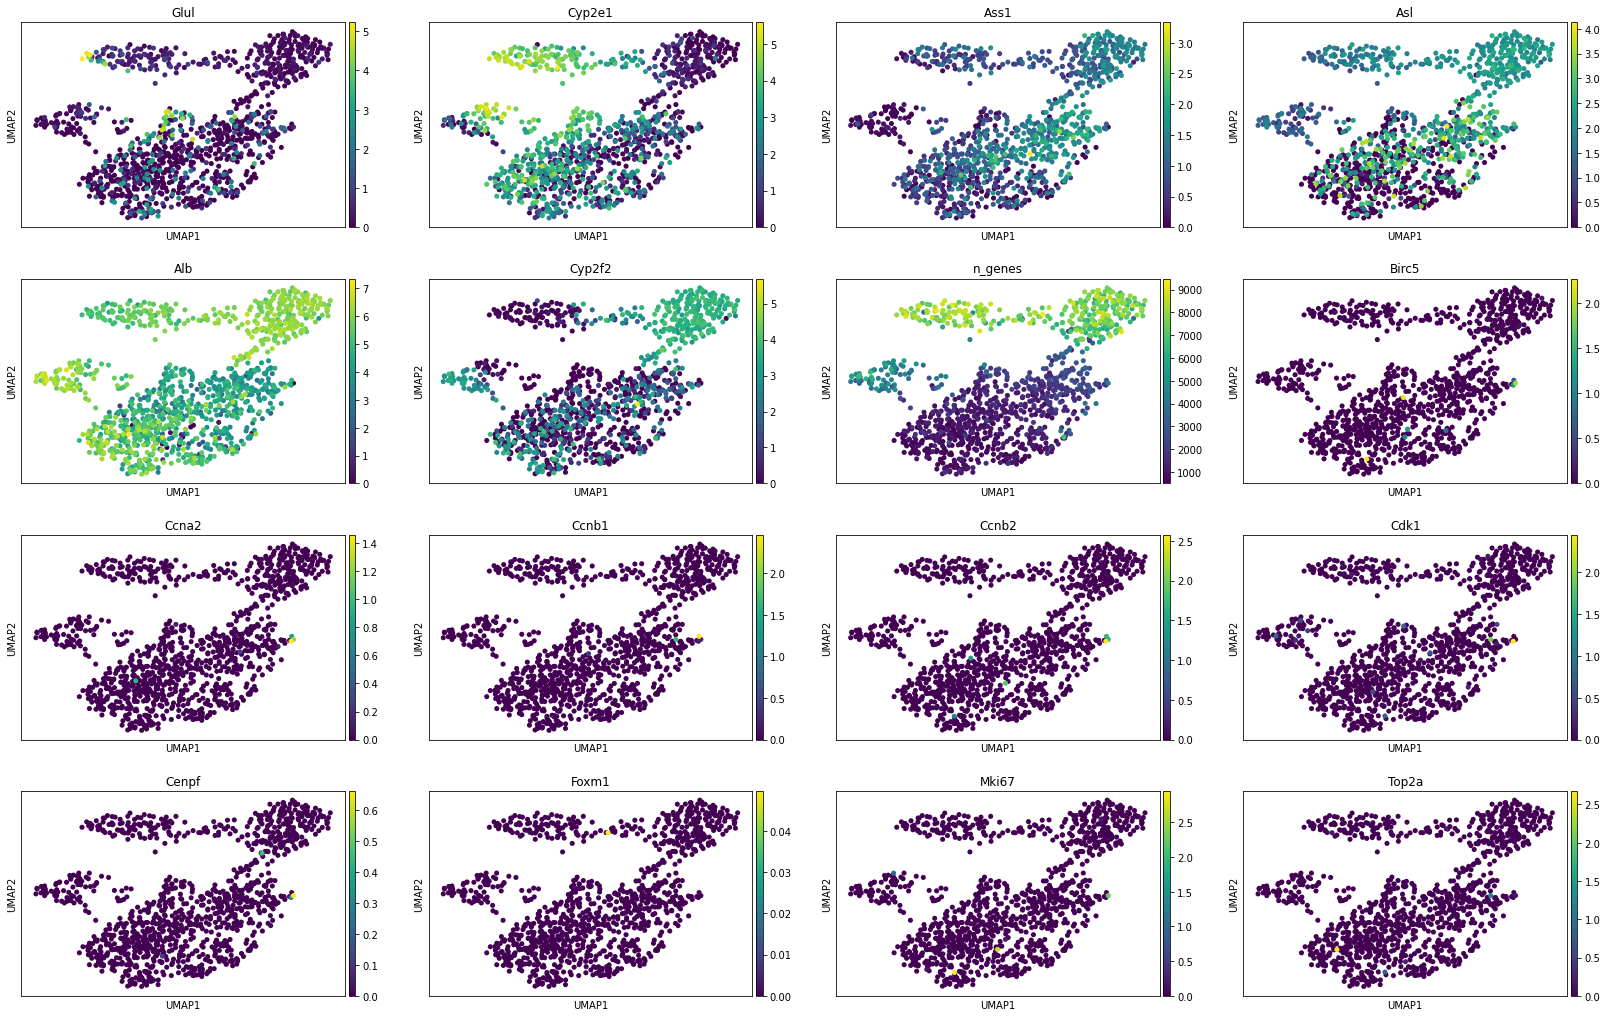

In [41]:
# trait = 'UKB_460K.biochemistry_HDLcholesterol'
trait = 'UKB_460K.biochemistry_LDLdirect'
ds = 'facs'

# Assign sig label for each leiden cluster (remove sig cells in small clusters)
# adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm

adata.obs = adata.obs.join(dic_score[ds]['%s.fdr'%trait])
adata.obs['leiden_sig'] = ['%s.sig'%x if y<0.1 else 'nonsig'
                           for x,y in zip(adata.obs['leiden'], adata.obs['%s.fdr'%trait])]
adata.obs['leiden_hq'] = ['hq' if x in ['2', '4'] else 'lq' for x in adata.obs['leiden']]

temp_df = adata.obs.groupby(['leiden_sig']).agg({'cell':len})
cluster_remove_list = list(temp_df.index[temp_df['cell']<50])
adata.obs.loc[adata.obs['leiden_sig'].isin(cluster_remove_list), 'leiden_sig'] = 'nonsig' 


# Specifically expressed genes 
group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
# sc.tl.rank_genes_groups(adata, groupby='leiden_sig', groups=group_list, method='wilcoxon')
# sc.tl.rank_genes_groups(adata, groupby='leiden_sig', reference='rest', groups=group_list+['nonsig'])
sc.tl.rank_genes_groups(adata, groupby='leiden_hq')
# adata.obs['leiden_annot'] = [dic_config[x][1] for x in adata.obs['leiden_sig']]
sc.pl.rank_genes_groups(adata, fontsize=10, ncols=2, n_genes=25)

# Marker gene expression 
marker_list = ['Apoe', 
               'Vldlr', 'Ldlr', 'Lrp1', 'Scarb1', 'Srebf2', 'Scap', 'Pcsk9', 'Sar1b', 'Itgav', 
#                'Adipoq', 'App', 'Itgb3', 'Psen1', 'Hnrnpk', 'Anxa2', 'Pparg', 'Cnpy2', # Lipoprotein receptor
#                'Alb', # Plasma protein secretion
#                'Fgb', 'F2', 'F9', 'Kng1', 'Aplp2', # Blood clotting factors 
#                'Gc', # Vitamin D
#                'G6pc', # Glycogenolysis and gluconeogenesis
#                'Cyp', 'Glul', 'Oat', 'Ces3a', 'Slc22a1', 'Aldh3a2', # Detoxification
#                'Akr1c6', 'Abcb4', # Bile acid synthesis
#                'Blvrb', # Heme synthesis
#                'Csad', # Amino acid metabolism
#                'Rgn', # Calcium homeostasis
#                'Hmgcl', # Ketogenesis
#                'Stard10', 'Apoa', 'Apoc', # Hormone, vitamin, and lipid transport
#                'Hmgcs2', 'Aldh2', 'Ppara', 'MGll', # Cholesterol, alcohol and lipid metabolism
#                'Agt', 'Igfbp2', 'Igfbp4', # Hormone synthesis and secretion
#                'Hamp', 'Ftl1', 'Hp', # Iron homeostasis and storage
#                'Ass1', 'Asl', # Urea synthesis from ammonia 
#                'Gpx1', # Glutathione synthesis 
#                'Pck1', 'Fbp1', # Gluconeogenesis
#                'Arg1', # Urea synthesis from arginine
#                'Cat', # Catalase production
#                'Cox', 'Nduf' # Respiration (b-oxidation)
#                'Glul', 'Apoe', 'Cyp1a2', 'Cyp2e1', 'Cyp2f2', 'Cyp2e1', # Central
#                'Arg1', 'Alb', 'Pck1' # Periportal
              ]
for gene in marker_list.copy():
    if gene not in adata.var_names:
        marker_list.remove(gene)
        print('# Removed: %s'%gene)
sc.pl.dotplot(adata, marker_list, groupby='leiden_sig')

# Zonation markers
marker_list = ['Glul', 'Cyp2e1', 'Ass1', 'Asl', 'Alb', 'Cyp2f2', 'n_genes', 
               'Birc5', 'Ccna2', 'Ccnb1', 'Ccnb2', 'Cdk1', 'Cenpf', 'Foxm1', 'Mki67', 'Top2a']
sc.pl.umap(adata, color=marker_list)

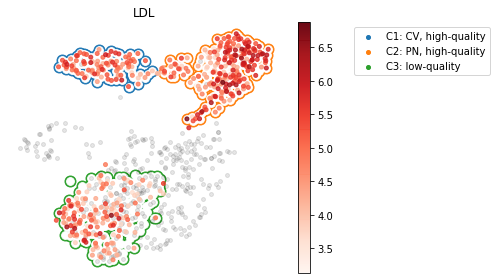

In [24]:
# UMAP plot with annotations 
# group_list = sorted([x for x in adata.obs['leiden_sig'].unique() if '.sig' in x])
group_list = ['4.sig', '2.sig', '0.sig']
dic_config = {'0.sig': ['C2', 'C3: low-quality'],
              # Pericentral
              '2.sig': ['C1', 'C2: PN, high-quality'], 
              # Periportal 
              '4.sig': ['C0', 'C1: CV, high-quality'], 
              # Pericentral 
              'nonsig': ['k', 'nonsig']
             }

# Get df_plot 
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['leiden', 'leiden_sig']])
df_plot = df_plot.loc[dic_cell_list[ds]]
df_plot = df_plot.join(dic_score[ds][['%s.fdr'%trait, '%s.nlog10_pval'%trait, '%s.norm_score'%trait]])
df_plot.sort_values('%s.fdr'%trait, ascending=False, inplace=True)

# Figure 
plt.figure(figsize=[7,4])
ax = plt.subplot(1,1,1)
ax.axis('off')

# Cluster boundry 
x_range = df_plot['UMAP1'].max()-df_plot['UMAP1'].min()
y_range = df_plot['UMAP2'].max()-df_plot['UMAP2'].min()
for cluster in group_list:
    ind_select = df_plot['leiden']==cluster.split('.')[0]
    temp_df = df_plot.loc[ind_select, ['UMAP1', 'UMAP2']].copy()
    xmin = np.quantile(temp_df['UMAP1'], 0.05)-0.05*x_range,
    xmax = np.quantile(temp_df['UMAP1'], 0.95)+0.05*x_range
    ymin = np.quantile(temp_df['UMAP2'], 0.05)-0.05*y_range,
    ymax = np.quantile(temp_df['UMAP2'], 0.95)+0.05*y_range
    ind_select = (temp_df['UMAP1']>xmin) & (temp_df['UMAP1']<xmax) & \
                    (temp_df['UMAP2']>ymin) & (temp_df['UMAP2']<ymax)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'][:2], temp_df.loc[ind_select, 'UMAP2'][:2],
                s=16, color=dic_config[cluster][0], 
                label=dic_config[cluster][1], zorder=0)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=120, color=dic_config[cluster][0], zorder=1)
    plt.scatter(temp_df.loc[ind_select, 'UMAP1'], temp_df.loc[ind_select, 'UMAP2'],
                s=60, color='w', zorder=2)

ind_select_sig = (df_plot['leiden_sig']!='nonsig')
np.random.seed(0)
cell_list_nonsig = np.random.choice(df_plot.index[~ind_select_sig], 
                                    size=int((~ind_select_sig).sum()*0.5), replace=False)
plt.scatter(df_plot.loc[cell_list_nonsig, 'UMAP1'], df_plot.loc[cell_list_nonsig, 'UMAP2'],
                c='k', s=16, alpha=0.1, zorder=5)

vmax = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.99) + 0.5
vmin = np.quantile(df_plot.loc[ind_select_sig, '%s.norm_score'%trait], 0.01) - 0.5
plt.scatter(df_plot.loc[ind_select_sig, 'UMAP1'], df_plot.loc[ind_select_sig, 'UMAP2'], 
            c=df_plot.loc[ind_select_sig, '%s.norm_score'%trait],
            cmap='Reds', s=16, vmax=vmax, vmin=vmin, alpha=0.8, zorder=10)
plt.colorbar()
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left')
plt.title(DF_TRAIT_INFO.loc[trait, 'Code'])
plt.tight_layout()
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_LDL_umap.svg')
plt.savefig(FIG_PATH+'/sctrs_assoc.annot_LDL_umap.png')
plt.show()

4
1
3
0
2
5


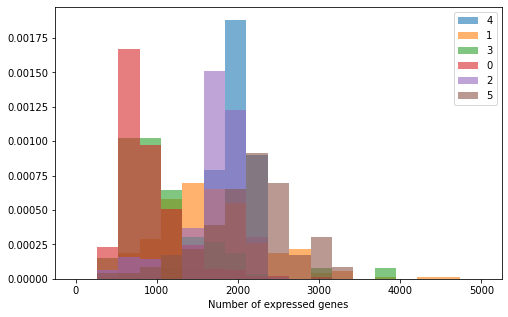

In [32]:
# n_gene 
bins_ = np.linspace(0,5000,20)
plt.figure(figsize=[8,5])
# plt.hist(dic_data_raw['facs'].obs['n_genes'], bins=bins_, alpha=0.6, label='ALL TMS', density=True)
for cluster in set(adata.obs['leiden']):
    cell_list = adata.obs_names[adata.obs['leiden']==cluster]
    if cluster in ['2', '4']:
        factor=1/4
    elif cluster in ['5']:
        factor=1/2
    else:
        factor=1
    plt.hist(dic_data_raw['facs'].obs.loc[cell_list, 'n_genes']*factor, bins=bins_, alpha=0.6,
             label=cluster, density=True)
    print(cluster)
plt.xlabel('Number of expressed genes')
plt.legend()
plt.show()

In [36]:
cluster

'4'

4
1
3
7
8
0
2
9
6
5


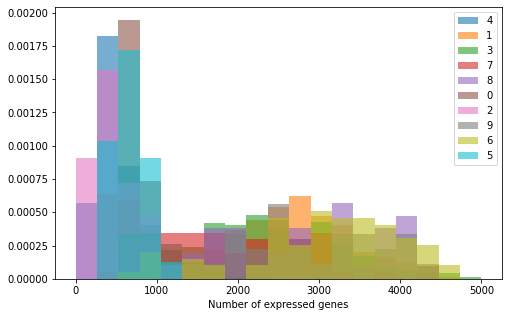

In [37]:
# n_gene 
bins_ = np.linspace(0,5000,20)
plt.figure(figsize=[8,5])
# plt.hist(dic_data_raw['facs'].obs['n_genes'], bins=bins_, alpha=0.6, label='ALL TMS', density=True)
for cluster in set(dic_data_proc['aizarani'].obs['leiden']):
    cell_list = dic_data_proc['aizarani'].obs_names[dic_data_proc['aizarani'].obs['leiden']==cluster]
    if cluster in ['2', '4']:
        factor=1/4
    elif cluster in ['5']:
        factor=1/2
    else:
        factor=1
    plt.hist(dic_data_raw['aizarani'].obs.loc[cell_list, 'n_genes']*factor, bins=bins_, alpha=0.6,
             label=cluster, density=True)
    print(cluster)
plt.xlabel('Number of expressed genes')
plt.legend()
plt.show()

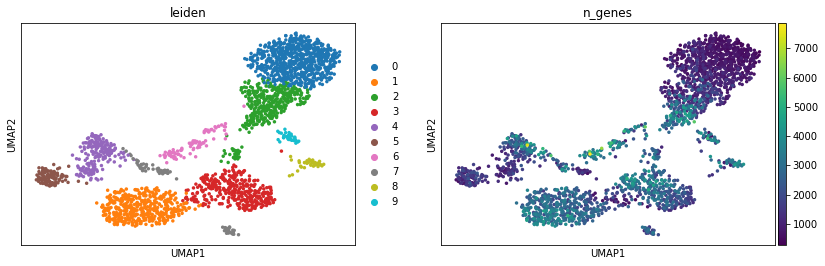

In [39]:
sc.pl.umap(dic_data_proc['aizarani'], color=['leiden', 'n_genes'])

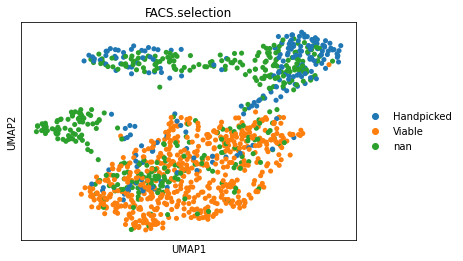

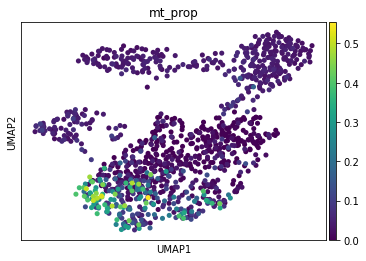

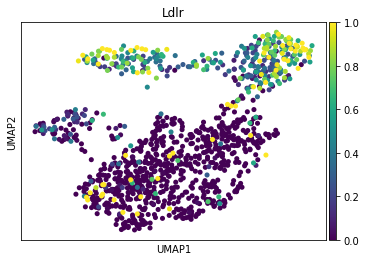

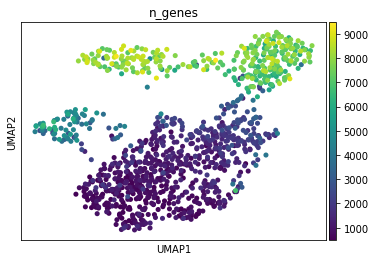

In [22]:
# Correspondance to FACS.selection, mito_prop, LDLR expression
sc.pl.umap(adata, color='FACS.selection')
sc.pl.umap(adata, color='mt_prop')
sc.pl.umap(adata, color='Ldlr', vmax=1)
sc.pl.umap(adata, color='n_genes')

In [ ]:
# Mitochr

In [39]:
trait='PASS_LDL'

In [40]:
adata_sub = adata[adata.obs['leiden_sig'].isin(['2.sig', '4.sig']),:].copy()
adata_sub.obs = adata_sub.obs.join(dic_score['facs'][['%s.norm_score'%trait]])

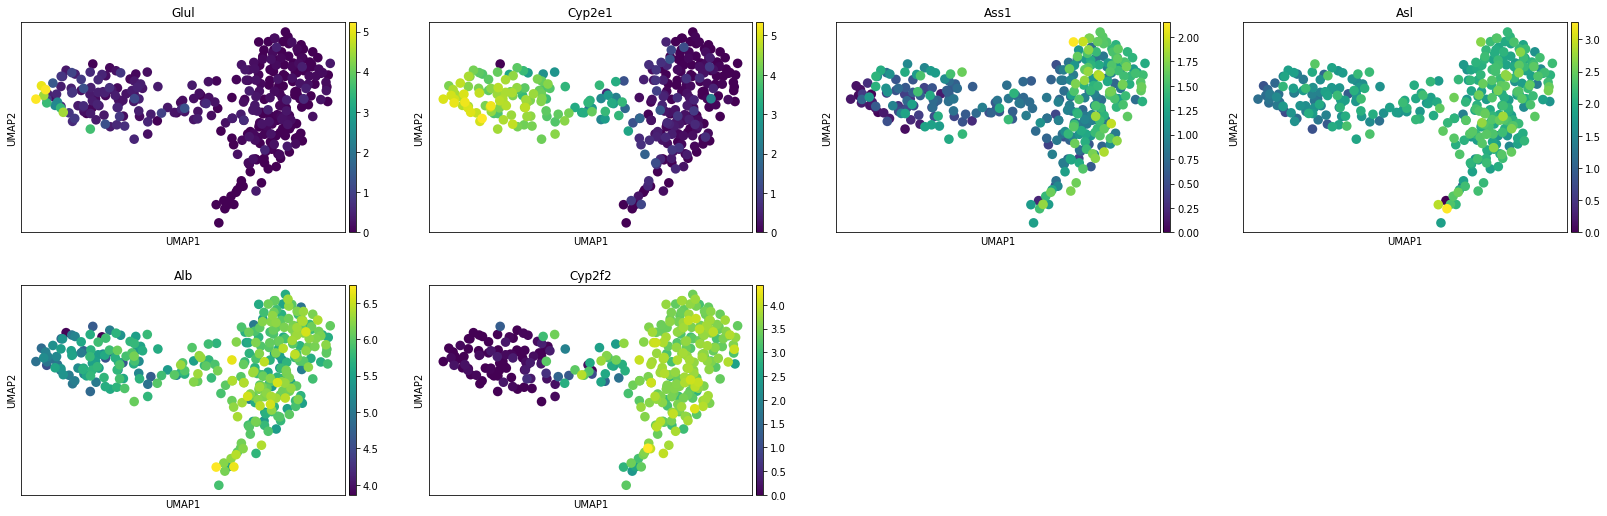

In [32]:
sc.pl.umap(adata_sub, color=['Glul', 'Cyp2e1', 'Ass1', 'Asl', 'Alb', 'Cyp2f2'])

<AxesSubplot:xlabel='zonation_bin', ylabel='score'>

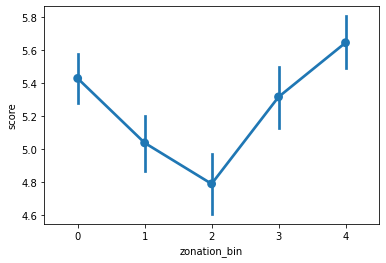

In [41]:
df_plot = pd.DataFrame(data={'zonation':adata_sub.obsm['X_umap'][:,0].flatten(), 
                             'score': adata_sub.obs['%s.norm_score'%trait]})
df_plot['zonation_bin'] = pd.qcut(df_plot['zonation'], 5, labels=False)
sns.pointplot(data=df_plot, x='zonation_bin', y='score')
# plt.scatter(adata_sub.obsm['X_umap'][:,0].flatten(), adata_sub.obs['%s.norm_score'%trait])

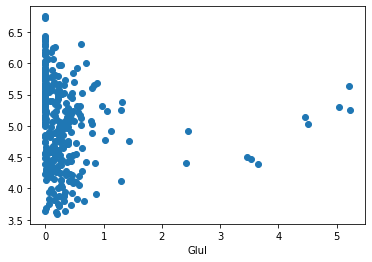

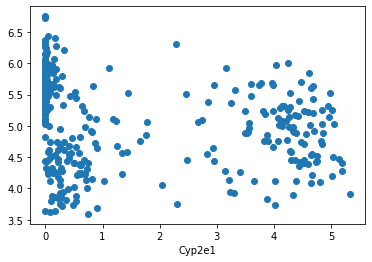

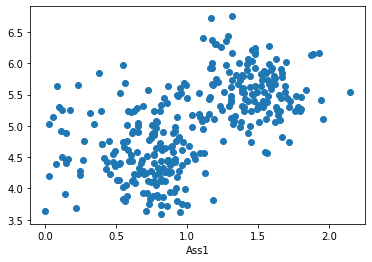

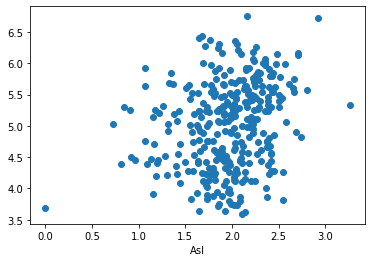

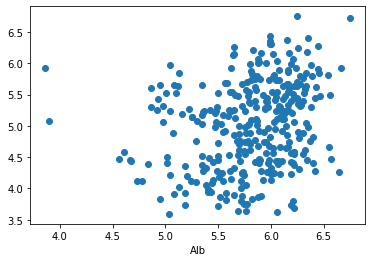

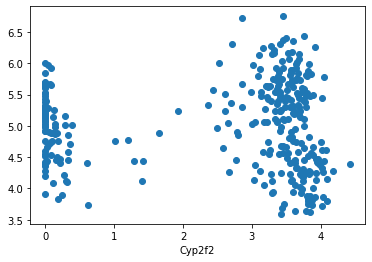

In [57]:
for gene in ['Glul', 'Cyp2e1', 'Ass1', 'Asl', 'Alb', 'Cyp2f2']:
    plt.figure()
    plt.scatter(adata_sub[:,gene].X.toarray().flatten(), adata_sub.obs['%s.norm_score'%trait])
    plt.xlabel(gene)
    plt.show()

4.sig
2.sig
0.sig
nonsig


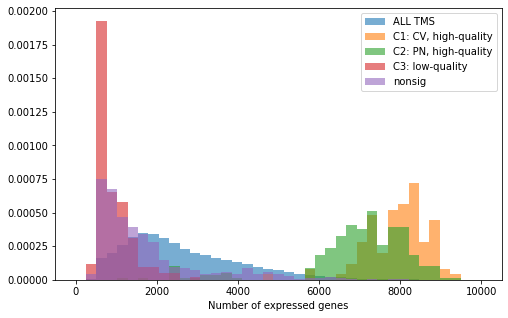

In [25]:
# n_gene 
bins_ = np.linspace(0,10000,40)
plt.figure(figsize=[8,5])
plt.hist(dic_data_raw['facs'].obs['n_genes'], bins=bins_, alpha=0.6, label='ALL TMS', density=True)
for cluster in group_list+['nonsig']:
    cell_list = adata.obs_names[adata.obs['leiden_sig']==cluster]
    plt.hist(dic_data_raw['facs'].obs.loc[cell_list, 'n_genes'], bins=bins_, alpha=0.6,
             label=dic_config[cluster][1], density=True)
    print(cluster)
plt.xlabel('Number of expressed genes')
plt.legend()
plt.show()

... storing 'leiden_annot' as categorical


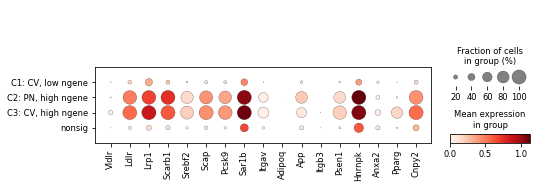

In [14]:
marker_list = ['Vldlr', 'Ldlr', 'Lrp1', 'Scarb1', 'Srebf2', 'Scap', 'Pcsk9', 'Sar1b', 'Itgav', 
               'Adipoq', 'App', 'Itgb3', 'Psen1', 'Hnrnpk', 'Anxa2', 'Pparg', 'Cnpy2'] # Lipoprotein receptor
adata.obs['leiden_annot'] = [dic_config[x][1] for x in adata.obs['leiden_sig']]
sc.pl.dotplot(adata, marker_list, groupby='leiden_annot')

In [14]:
# Pathway: enrichr
dic_pathway = {}
group_list = list(adata.uns['rank_genes_groups']['names'].dtype.names)
pw_list = []
# for group in group_list+['nonsig']:
for group in ['hq', 'lq']:
    df_gene = sc.get.rank_genes_groups_df(adata, group=group)
    gene_list = list(df_gene['names'][:100])

    res = gp.enrichr(gene_list=gene_list, description='pathway',
                         gene_sets=['KEGG_2019_Mouse', 'GO_Biological_Process_2018', 'Reactome_2016'],
                         organism='Mouse', outdir=None)
    df_pathway = res.results
    df_pathway = df_pathway.loc[df_pathway['Adjusted P-value']<0.01].copy()
    df_pathway['Intersect'] = [int(x.split('/')[0]) for x in df_pathway['Overlap']]
    df_pathway['Term_size'] = [int(x.split('/')[1]) for x in df_pathway['Overlap']]
    df_pathway['Recall'] = df_pathway['Intersect'] / df_pathway['Term_size']
    dic_pathway[group] = df_pathway.copy()
    ind_select = (df_pathway['Intersect']>20) | (df_pathway['Recall']>0.20)
    ind_select = ind_select & (df_pathway['Term_size']>10) & (df_pathway['Term_size']<500) 
    pw_list.extend(df_pathway.loc[ind_select, 'Term'])

# for group in group_list:
for group in ['hq', 'lq']:
    dic_pathway[group].index = dic_pathway[group]['Term']
    dic_pathway[group] = dic_pathway[group].loc[set(dic_pathway[group].index) & set(pw_list)]

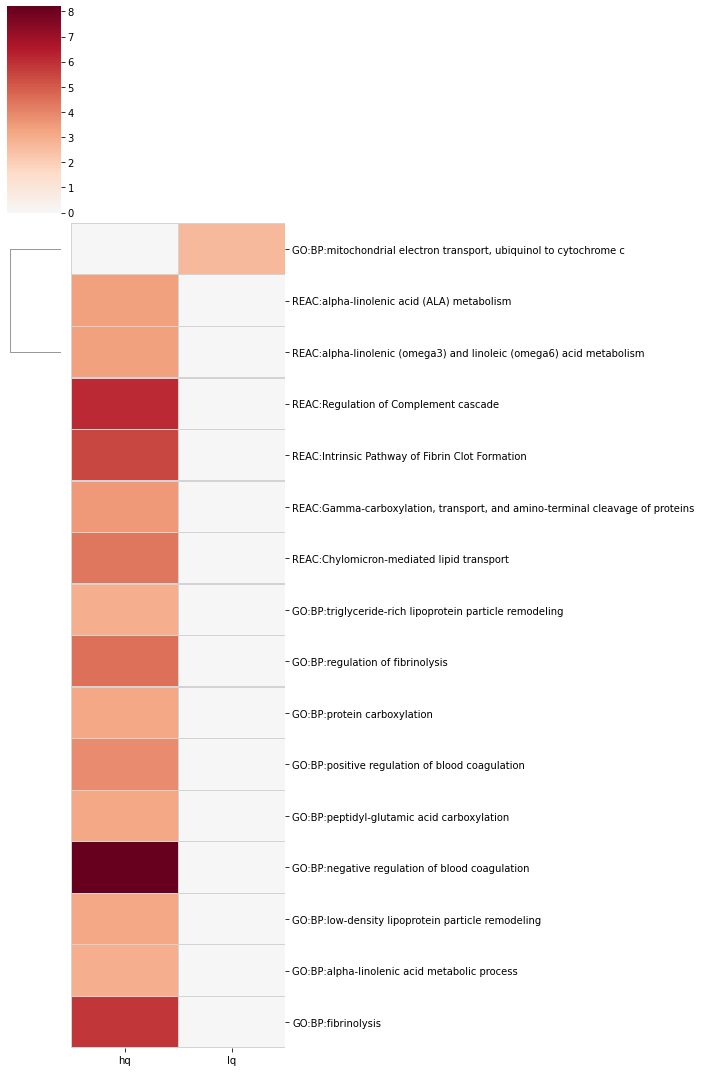

In [15]:
df_plot = pd.DataFrame()
dic_source = {'KEGG_2019_Mouse':'KEGG', 'GO_Biological_Process_2018':'GO:BP', 'Reactome_2016':'REAC'}
for group in group_list:
    temp_df = dic_pathway[group][['Adjusted P-value']]
    temp_df.index = ['%s:%s'%(dic_source[x],y.split(' (GO')[0].split(' Homo')[0]) 
                     for x,y in zip(dic_pathway[group]['Gene_set'], dic_pathway[group]['Term'])]
    temp_df.columns = [group]
    df_plot = df_plot.join(temp_df, how='outer')

df_plot.fillna(1, inplace=True)
df_plot = -np.log10(df_plot)
# df_plot = df_plot.loc[df_plot.max(axis=1)>3]
# df_plot = df_plot[group_list]
df_plot = df_plot[['hq', 'lq']]
df_plot.index.name = ''
# df_plot.columns = [dic_config[x][1].split(':')[0] for x in df_plot.columns]

sns.clustermap(df_plot, metric='cosine', col_cluster=False, 
               figsize=(10,15), cbar_pos=(0, 0.9, 0.05, 0.05),
               cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')

# sns.clustermap(df_plot, metric='euclidean', col_cluster=False, 
#                figsize=(10,10), cbar_pos=(0, 0.9, 0.05, 0.05),
#                cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/IBD_pathway.svg')
plt.show()

In [18]:
# Compute genes driving each cluster 
df_gs_gwas = pd.read_csv(GS_FILE, sep='\t', index_col=0)
df_hom = pd.read_csv(DATA_PATH + '/gene_annotation/mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
gwas_gene_list = [dic_map[x] for x in df_gs_gwas.loc[trait, 'GENESET'].split(',') if x in dic_map]
df_contrib = md.compute_gene_contrib(adata, gwas_gene_list)

df_contrib_stats = pd.DataFrame(index=df_contrib.columns, columns=group_list, data=0)
for group in group_list:
    cell_list = list(adata.obs_names[adata.obs['leiden_sig']==group])
    temp_df_sig = df_contrib.loc[cell_list].copy()
    temp_df_rest = df_contrib.loc[~df_contrib.index.isin(cell_list)]
    df_contrib_stats[group] = [sp.stats.ttest_ind(temp_df_sig[x].values, temp_df_rest[x].values)[0]
                               for x in df_contrib.columns]

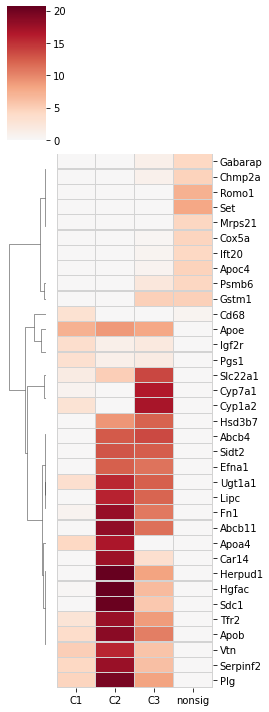

In [19]:
gene_list = []
for group in df_contrib_stats.columns:
    gene_list.extend(df_contrib_stats.sort_values(by=group, ascending=False).index[:10])
gene_list = list(set(gene_list))
df_plot = df_contrib_stats.loc[gene_list]
df_plot.values[df_plot.values<0] = 0
df_plot = df_plot[group_list]
df_plot.columns = [dic_config[x][1].split(':')[0] for x in df_plot.columns]

sns.clustermap(df_plot, metric='cosine', col_cluster=False, figsize=(4,10), 
               cbar_pos=(0, 0.8, 0.05, 0.05), cmap='RdBu_r', center=0, linewidths=0.2, linecolor='lightgrey')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/IBD_trs_contrib_gene.svg')
plt.show()

### Correlation with zonation 

In [47]:
# Get data and zonation profile 
dic_data_zon = {}

# FACS hep data 
ds = 'facs'
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obs = adata.obs.join(temp_adata.obs[[x for x in temp_adata.obs.columns if x not in adata.obs.columns]])
adata.obsm = temp_adata.obsm
adata = adata[adata.obs['leiden'].isin(['2', '4'])].copy()
adata.obs['zonation'] = adata.obsm['X_umap'][:,0]
adata.obs['ctrl'] = adata[:,'Alb'].X.toarray().flatten()
adata.obs['zonation_bin'] = pd.qcut(adata.obs['zonation'], 5, labels=False)
temp_dic = {0:-1, 1:-1, 2:0, 3:0, 4:1}
adata.obs['zonation_bin_o'] = [temp_dic[x] for x in adata.obs['zonation_bin']]
dic_data_zon['facs'] = adata.copy()

# aizarani hep data
ds = 'aizarani'
temp_df = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/liver_atlas/'
                      'Aizarani_Nature_2019_liver_supp_table3.txt', sep='\t', index_col=1)
adata = dic_data_raw[ds][dic_cell_list[ds], :].copy()
adata.obs['cluster_id'] = adata.obs['cluster_id'].astype('category')
temp_adata = dic_data_proc[ds][dic_cell_list[ds], :].copy()
adata.obsm = temp_adata.obsm
adata.obs['n_genes'] = (adata.X>0).sum(axis=1)
# adata.obs = adata.obs.join(dic_score['aizarani'][['%s.fdr'%trait, '%s.norm_score'%trait]])
adata.obs['zonation'] = -1
# adata.obs['zonation_bin'] = pd.qcut(adata.obs['zonation'], 5, labels=False)
temp_list = [x for x in temp_df.columns if x in adata.obs_names]
adata.obs.loc[temp_list, 'zonation'] = np.arange(len(temp_list))
adata = adata[adata.obs['zonation']>=0,:].copy()
adata.obs['zonation_bin'] = pd.qcut(adata.obs['zonation'], 5, labels=False)
adata.obs['ctrl'] = adata[:,'ALB'].X.toarray().flatten()
adata = adata[adata.obs['n_genes']<=1500,:].copy()
# adata = adata[adata.obs['%s.fdr'%trait]<0.1].copy()
dic_data_zon['aizarani'] = adata.copy()

In [48]:
# Compute p-value
df_stats = pd.DataFrame(columns=['DPT', 'TRAIT', 'CORR', 'P'])


for dpt in ['zonation']:
    for ds in ['aizarani']:
        for trait in DIC_TRAIT_LIST['aizarani.hm']:
            df_plot = dic_data_zon[ds].obs[[dpt, 'ctrl']].copy()
            df_plot = df_plot.join(dic_score['aizarani.hm'].loc[dic_data_zon[ds].obs_names, ['%s.norm_score'%trait]])
            df_plot = df_plot.join(dic_ctrl_score['aizarani.hm'][trait])
            corr_ = sp.stats.pearsonr(df_plot[dpt].values, df_plot['%s.norm_score'%trait].values)[0]
#             corr_ = sp.stats.spearmanr(df_plot[dpt].values, df_plot['%s.norm_score'%trait].values)[0]
            v_corr_ = np.zeros(500)
            for i in range(500):
                v_corr_[i] = sp.stats.pearsonr(df_plot[dpt].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
#                 v_corr_[i] = sp.stats.spearmanr(df_plot[dpt].values, df_plot['ctrl_norm_score_%d'%i].values)[0]
            p_ = ((corr_ <= v_corr_).sum()+1) / 501
            df_stats.loc['%s.%s'%(dpt,trait)] = [dpt, trait, corr_, p_]
            
def p_2_str(p_):
    if p_>0.05:
        return 'n.s.'
    elif p_>0.01:
        return '*'
    elif p_>0.005:
        return '**'
    else: 
        return '***'
    
def p_2_str_num(p_):
    if p_>1/500.5:
        return 'P=%0.3f'%p_
    else:
        return 'P<0.002'
    
df_stats['P_STR'] = [p_2_str(x) for x in df_stats['P']]
df_stats['P_STR_NUM'] = [p_2_str_num(x) for x in df_stats['P']]

In [49]:
df_stats

,DPT,TRAIT,CORR,P,P_STR,P_STR_NUM
zonation.Beta-oxidation,zonation,Beta-oxidation,0.084765,0.227545,n.s.,P=0.228
zonation.Cholesterol biosynthesis,zonation,Cholesterol biosynthesis,0.029632,0.349301,n.s.,P=0.349
zonation.Glycolysis,zonation,Glycolysis,-0.143875,0.948104,n.s.,P=0.948
zonation.Protein secretion,zonation,Protein secretion,0.163892,0.029940,*,P=0.030
zonation.Bile acid production,zonation,Bile acid production,0.075667,0.191617,n.s.,P=0.192
zonation.Gluconeogenesis,zonation,Gluconeogenesis,-0.161923,0.916168,n.s.,P=0.916
zonation.Lipogenesis,zonation,Lipogenesis,-0.015325,0.562874,n.s.,P=0.563
zonation.Xenobiotic metabolism,zonation,Xenobiotic metabolism,0.322297,0.003992,***,P=0.004


In [81]:
sp.stats.pearsonr(df_plot[dpt].values, df_plot['ctrl'].values)[0]

0.43842491823771557

In [91]:
from statsmodels.stats.multitest import multipletests

In [122]:
multipletests(v_p/5, method='fdr_bh')

(array([False,  True, False,  True,  True,  True, False,  True]),
 array([0.07904192, 0.04023952, 0.07436555, 0.04023952, 0.04023952,
        0.03832335, 0.05854957, 0.04023952]),
 0.006391150954545011,
 0.00625)

In [123]:
v_p/5

array([0.07904192, 0.01996008, 0.06506986, 0.01996008, 0.02195609,
       0.00479042, 0.04391218, 0.0251497 ])

In [117]:
v_p = np.array([min(x, 1-x) for x in df_stats['P']])

In [102]:
df_stats

,DPT,TRAIT,CORR,P,P_STR,P_STR_NUM
zonation_bin.Beta-oxidation,zonation_bin,Beta-oxidation,0.105355,0.395210,n.s.,P=0.395
zonation_bin.Cholesterol biosynthesis,zonation_bin,Cholesterol biosynthesis,-0.241579,0.900200,n.s.,P=0.900
zonation_bin.Glycolysis,zonation_bin,Glycolysis,0.095046,0.325349,n.s.,P=0.325
zonation_bin.Protein secretion,zonation_bin,Protein secretion,0.387076,0.099800,n.s.,P=0.100
zonation_bin.Bile acid production,zonation_bin,Bile acid production,-0.418860,0.890220,n.s.,P=0.890
zonation_bin.Gluconeogenesis,zonation_bin,Gluconeogenesis,0.516162,0.023952,*,P=0.024
zonation_bin.Lipogenesis,zonation_bin,Lipogenesis,0.167519,0.219561,n.s.,P=0.220
zonation_bin.Xenobiotic metabolism,zonation_bin,Xenobiotic metabolism,-0.450094,0.874251,n.s.,P=0.874


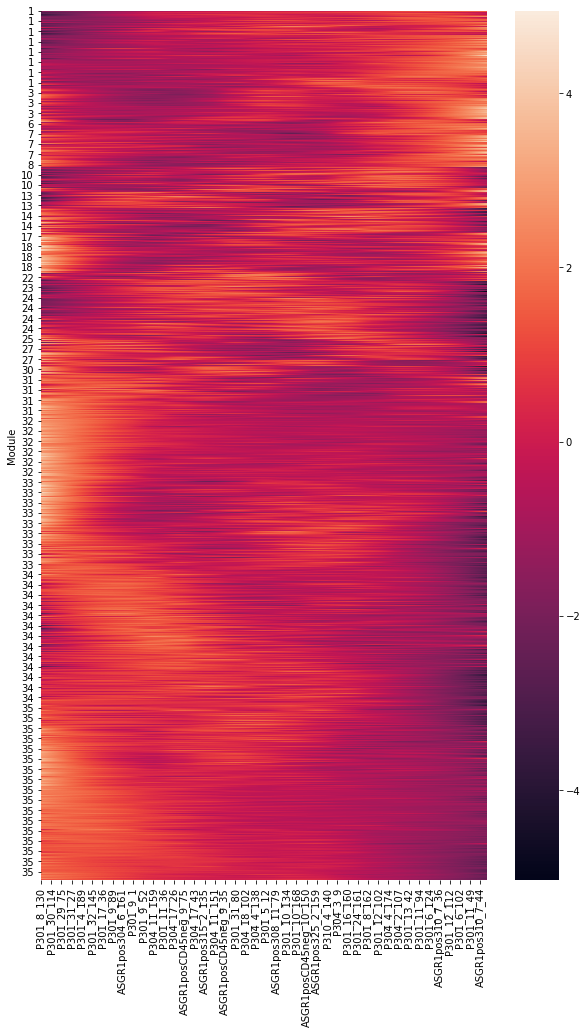

In [95]:
plt.figure(figsize=[10,16])
sns.heatmap(temp_df.iloc[:,1:])
plt.show()

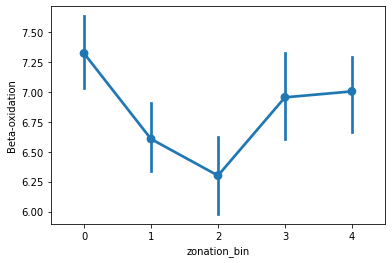

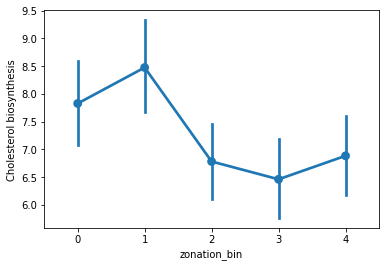

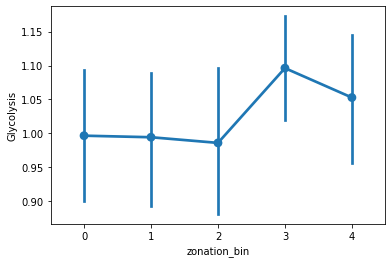

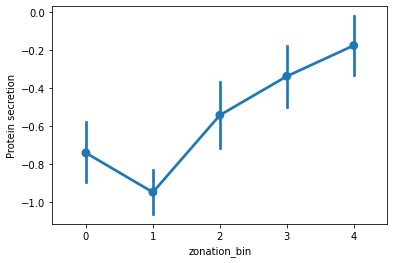

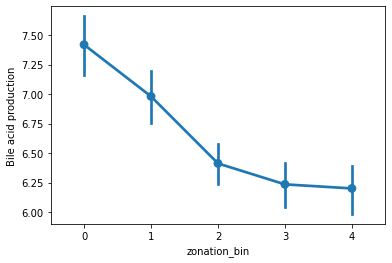

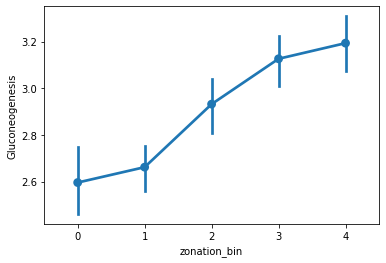

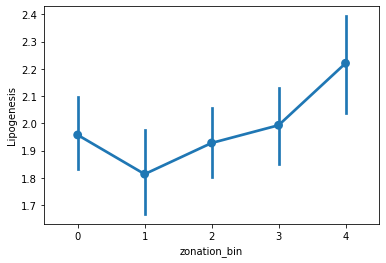

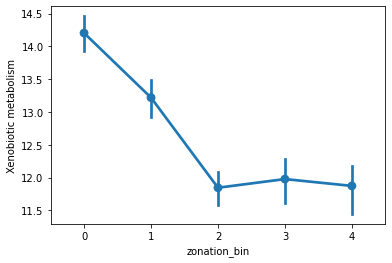

In [19]:
df = 'facs'
for trait in DIC_TRAIT_LIST['facs.hm']:
    
    df_plot = pd.DataFrame(data={'zonation': dic_data_zon[ds].obs['zonation'], 
                                 trait: dic_score['facs.hm'].loc[dic_data_zon[ds].obs_names, '%s.norm_score'%trait],
                                 'ctrl': dic_data_zon[ds].obs['ctrl']})
    df_plot['zonation_bin'] = pd.qcut(df_plot['zonation'], 5, labels=False)
    plt.figure()
    sns.pointplot(data=df_plot, x='zonation_bin', y=trait)
    plt.show()

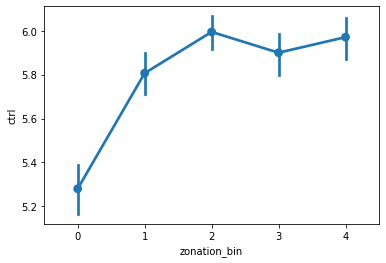

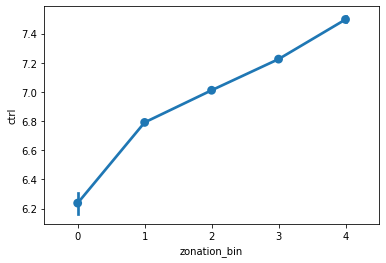

In [25]:
trait = 'UKB_460K.biochemistry_TotalBilirubin'
for ds in DS_LIST:
    
    df_plot = pd.DataFrame(data={'zonation': dic_data_zon[ds].obs['zonation'], 
                                 'score': dic_score[ds].loc[dic_data_zon[ds].obs_names, '%s.norm_score'%trait],
                                 'ctrl': dic_data_zon[ds].obs['ctrl']})
    df_plot['zonation_bin'] = pd.qcut(df_plot['zonation'], 5, labels=False)
    plt.figure()
    sns.pointplot(data=df_plot, x='zonation_bin', y='ctrl')
    plt.show()

In [ ]:
sc.pl.umap(dic_data_zon['facs'], color=['%s.norm_score'%trait, 'zonation', 'n_genes', 'cluster_id'])

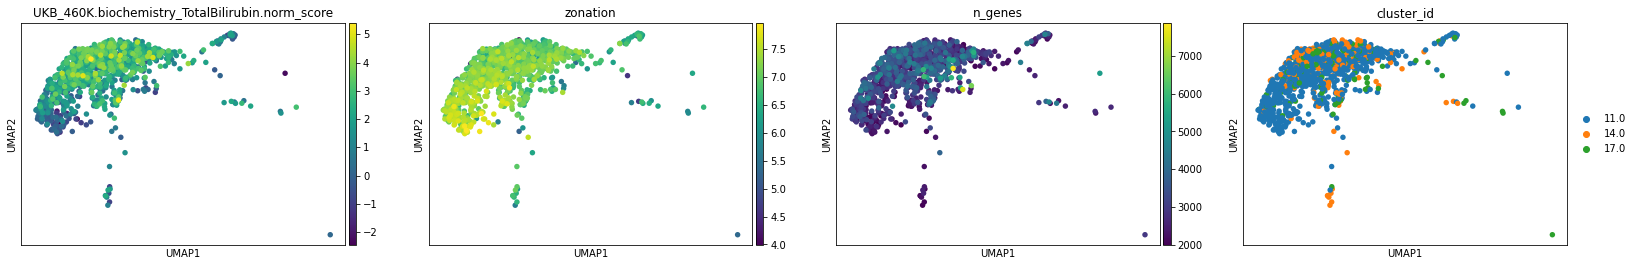

In [23]:
sc.pl.umap(dic_data_zon['aizarani'], color=['%s.norm_score'%trait, 'zonation', 'n_genes', 'cluster_id'])

In [122]:
dic_data_zon['aizarani'].obs['sig'] = dic_data_zon['aizarani'].obs['%s.fdr'%trait]<0.1
dic_data_zon['aizarani'].obs.groupby(['cluster_id', 'sig']).agg({'celltype':len})

celltype
cluster_id sig            
11.0       False       499
           True        228
14.0       False        85
           True         71
17.0       False        65
           True         55

In [117]:
temp_df

,GeneSymbol,P301_8_130,P301_8_127,P301_5_28,P301_4_98,P301_17_5,P301_10_123,P301_4_103,P301_8_131,P301_8_154,...,P301_6_175,P301_6_147,P301_18_146,P301_6_141,P301_6_153,P301_6_123,P301_6_181,P301_12_161,P301_6_178,P301_18_176
Module,,,,,,,,,,,,,,,,,,,,,
1,ACADM,-1.892985,-1.889814,-1.886645,-1.883479,-1.880315,-1.877153,-1.873993,-1.870836,-1.867681,...,-0.084579,-0.094507,-0.104455,-0.114421,-0.124406,-0.134410,-0.144433,-0.154474,-0.164533,-0.174611
1,AFM,-2.374369,-2.373595,-2.372819,-2.372039,-2.371257,-2.370472,-2.369684,-2.368893,-2.368099,...,0.565645,0.562683,0.559714,0.556738,0.553756,0.550767,0.547772,0.544771,0.541763,0.538749
1,AGL,-1.811760,-1.811965,-1.812166,-1.812363,-1.812555,-1.812744,-1.812929,-1.813109,-1.813285,...,2.140241,2.145407,2.150576,2.155749,2.160924,2.166102,2.171283,2.176467,2.181653,2.186842
1,ANTXR2,-1.799543,-1.797541,-1.795538,-1.793535,-1.791532,-1.789528,-1.787524,-1.785520,-1.783516,...,0.547106,0.546021,0.544938,0.543857,0.542777,0.541699,0.540624,0.539550,0.538479,0.537409
1,APLP2,-3.630012,-3.621315,-3.612630,-3.603959,-3.595299,-3.586652,-3.578018,-3.569395,-3.560785,...,0.962515,0.966911,0.971313,0.975720,0.980132,0.984550,0.988973,0.993401,0.997835,1.002273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,RPS19,1.950090,1.949356,1.948621,1.947886,1.947152,1.946417,1.945681,1.944946,1.944209,...,-2.185280,-2.188392,-2.191506,-2.194622,-2.197741,-2.200862,-2.203984,-2.207109,-2.210237,-2.213366
35,RPS9,1.899189,1.896911,1.894635,1.892362,1.890091,1.887822,1.885555,1.883291,1.881028,...,-2.033410,-2.034628,-2.035842,-2.037053,-2.038260,-2.039464,-2.040665,-2.041862,-2.043056,-2.044246
35,SEC14L2,2.087039,2.084403,2.081768,2.079134,2.076500,2.073868,2.071236,2.068605,2.065975,...,-1.725249,-1.725800,-1.726347,-1.726892,-1.727434,-1.727972,-1.728507,-1.729040,-1.729569,-1.730095


In [56]:
trait = 'UKB_460K.biochemistry_LDLdirect'

In [46]:
dic_data_zon['aizarani'].obs.loc['P301_8_130']

cluster_id             14
cell_id        P301_8_130
celltype      hepatocytes
n_counts          11997.8
zonation                0
Name: P301_8_130, dtype: object

In [35]:
set(temp_df.columns) - set(adata.obs_names)

{'GeneSymbol'}

In [36]:
temp_df.shape

(3395, 2535)

In [32]:
[x for x in temp_df.columns if x[0]!='P']

['GeneSymbol',
 'ASGR1pos310_6_158',
 'ASGR1pos310_6_146',
 'ASGR1pos310_5_21',
 'ASGR1pos310_5_15',
 'ASGR1pos315_1_39',
 'ASGR1pos310_8_135',
 'ASGR1pos308_11_57',
 'ASGR1pos310_5_36',
 'ASGR1pos325_1_21',
 'ASGR1pos310_5_85',
 'ASGR1pos325_1_66',
 'LSEC325_14_168',
 'ASGR1pos310_6_149',
 'ASGR1pos308_9_93',
 'ASGR1pos304_7_32',
 'ASGR1pos308_10_130',
 'Mixed315_11_57',
 'ASGR1pos308_10_169',
 'ASGR1pos304_7_93',
 'ASGR1pos304_7_24',
 'ASGR1pos308_10_122',
 'ASGR1pos308_9_41',
 'ASGR1pos304_7_30',
 'ASGR1pos325_1_43',
 'ASGR1pos315_3_48',
 'ASGR1pos304_8_146',
 'ASGR1pos304_5_11',
 'ASGR1pos304_7_53',
 'ASGR1pos304_8_103',
 'ASGR1pos304_5_7',
 'Mixed315_12_155',
 'ASGR1pos310_5_20',
 'ASGR1pos304_6_106',
 'ASGR1pos304_5_56',
 'ASGR1pos308_9_81',
 'ASGR1pos315_2_129',
 'ASGR1pos304_6_143',
 'ASGR1pos304_8_127',
 'ASGR1pos304_7_78',
 'ASGR1pos304_6_127',
 'ASGR1pos315_3_92',
 'ASGR1pos308_10_146',
 'ASGR1pos308_12_142',
 'ASGR1pos304_8_129',
 'ASGR1pos315_3_6',
 'ASGR1posCD45neg_9_68',

In [ ]:
df_plot = pd.DataFrame(data={'zonation':adata_sub.obsm['X_umap'][:,0].flatten(), 
                             'score': adata_sub.obs['%s.norm_score'%trait]})
df_plot['zonation_bin'] = pd.qcut(df_plot['zonation'], 5, labels=False)
sns.pointplot(data=df_plot, x='zonation_bin', y='score')
# plt.scatter(adata_sub.obsm['X_umap'][:,0].flatten(), adata_sub.obs['%s.norm_score'%trait])

### Prioritize gene sets 

In [52]:
df_gs_gwas = pd.read_csv(GS_FILE, sep='\t', index_col=0)
df_hom = pd.read_csv(DATA_PATH + '/gene_annotation/mouse_human_homologs.txt', sep='\t')
dic_map = {x:y for x,y in zip(df_hom['HUMAN_GENE_SYM'], df_hom['MOUSE_GENE_SYM'])}
background_set = set(dic_data_raw['facs'].var_names) & set(dic_map.values())

In [54]:
# Hep specific genes 
temp_adata = dic_data_raw['facs'][:, list(background_set)].copy()
temp_adata.obs['hep'] = 'nh'
temp_adata.obs.loc[dic_data_proc['facs'].obs_names, 'hep'] = 'h'
sc.tl.rank_genes_groups(temp_adata, groupby='hep', groups=['h'])
df_h = sc.get.rank_genes_groups_df(temp_adata, 'h')

... storing 'tissue_celltype' as categorical
... storing 'hep' as categorical


In [87]:
# GWAS and scTRS gene sets 
dic_gs = {}

for trait in DIC_TRAIT_LIST['facs']:
    
    # GWAS gene set
    dic_gs['%s.gwas'%trait] = set([dic_map[x] for x in df_gs_gwas.loc[trait, 'GENESET'].split(',') if x in dic_map])
    dic_gs['%s.gwas'%trait] = dic_gs['%s.gwas'%trait] & background_set
    
    # scTRS gene set
#     temp_list = dic_data_proc['facs'].obs_names[dic_data_proc['facs'].obs['leiden'].isin(['2'])]
#     temp_adata = dic_data_raw['facs'][temp_list, list(background_set)].copy()
    temp_adata = dic_data_raw['facs'][dic_data_proc['facs'].obs_names, list(background_set)].copy()
    temp_adata.obs['sctrs'] = dic_score['facs'].loc[temp_adata.obs_names, '%s.norm_score'%trait]
    md.correlate_gene(temp_adata, trs_name='sctrs', corr_opt='pearson', cov_list=None)
    df_gene_corr = pd.DataFrame(index=temp_adata.var_names)
    df_gene_corr[trait] = temp_adata.var[['trs_corr']].copy()
    df_gene_corr.sort_values(by=trait, ascending=False, inplace=True)
    dic_gs['%s.sctrs'%trait] = set(df_gene_corr.index[:len(dic_gs['%s.gwas'%trait])])
    
    # tcell-specific genes 
    dic_gs['%s.hep'%trait] = set(df_h['names'][:len(dic_gs['%s.gwas'%trait])])

In [88]:
# Gold standard gene sets 
dic_ref = {'UKB_460K.biochemistry_TotalBilirubin': 'Forgetta_biorxiv_2020:dbilirubin.med',
           'UKB_460K.biochemistry_LDLdirect': 'Forgetta_biorxiv_2020:ldl.med;Forgetta_biorxiv_2020:ldl.drug',
           'UKB_460K.biochemistry_Triglycerides': 'Forgetta_biorxiv_2020:tg.med;Forgetta_biorxiv_2020:tg.drug',
           'UKB_460K.biochemistry_Cholesterol': 'Freund_AJHG_2018:Cardiovascular_Disease',
           'UKB_460K.biochemistry_HDLcholesterol': 'Freund_AJHG_2018:Cardiovascular_Disease'}
for trait in dic_ref: 
     dic_gs['%s.ref'%trait] = set()
        
for gs_ref in ['Freund_AJHG_2018', 'Forgetta_biorxiv_2020']:
    df_gs_gold = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gold_standard_gs/%s.gs'%gs_ref,
                         sep='\t', index_col=0)
#     break
    for trait in dic_ref:
        for trait_ref in dic_ref[trait].split(';'):
            if gs_ref in trait_ref:
                trait_ref = trait_ref.replace('%s:'%gs_ref,'')
                dic_gs['%s.ref'%trait] = dic_gs['%s.ref'%trait] | \
                    set([dic_map[x] for x in df_gs_gold.loc[trait_ref, 'GENESET'].split(',') if x in dic_map])

In [89]:
# Compute stats 
dic_stats = {}
for res in ['gwas', 'sctrs', 'hep']:
    dic_stats[res] = pd.DataFrame(columns=['GWAS', 'GS', 'overlap', 'odds_ratio', 'odds_ratio.ub',
                                           'odds_ratio.lb', 'pval', 'overlap_gene'], dtype=float)
    for trait in dic_ref:
        gs_set = dic_gs['%s.%s'%(trait, res)] & background_set
        ge_set_ref = dic_gs['%s.ref'%trait] & background_set
        pvalue,oddsratio,or_ub,or_lb = util.test_overlap(gs_set, ge_set_ref, background_set)

        dic_stats[res].loc[trait,'GWAS'] = len(gs_set)
        dic_stats[res].loc[trait,'GS'] = len(ge_set_ref)
        dic_stats[res].loc[trait,'overlap'] = len(gs_set & ge_set_ref)
        dic_stats[res].loc[trait,'odds_ratio'] = oddsratio
        dic_stats[res].loc[trait,'odds_ratio.ub'] = or_ub
        dic_stats[res].loc[trait,'odds_ratio.lb'] = or_lb
        dic_stats[res].loc[trait,'pval'] = pvalue
        dic_stats[res].loc[trait,'overlap_gene'] = ','.join(sorted(gs_set & ge_set_ref))

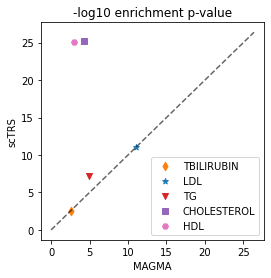

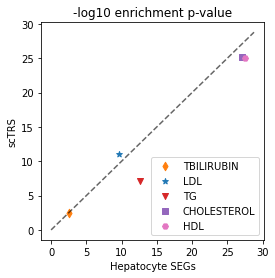

In [92]:
# Scatter plot for comparison 
dic_config = {'gwas': ['C0', 'MAGMA'], 
              'sctrs': ['C1', 'scTRS'], 
              'hep': ['C2', 'Hepatocyte SEGs']}

dic_config_trait = {'UKB_460K.biochemistry_TotalBilirubin': ['C1', 'd'], 
                    'UKB_460K.biochemistry_LDLdirect': ['C0', '*'], 
                    'UKB_460K.biochemistry_Triglycerides': ['C3', 'v'], 
                    'UKB_460K.biochemistry_Cholesterol': ['C4', 's'],
                    'UKB_460K.biochemistry_HDLcholesterol': ['C6', 'H'],
#                     'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED': ['C2', 'D']                   
                    }

df_plot = dic_stats[res][['GS']].copy()
for res in dic_config:
    df_plot['%s.nlog10pval'%res] = -np.log10(dic_stats[res].loc[df_plot.index, 'pval'].values)
df_plot = df_plot.astype(dtype=float)
df_plot['loc'] = range(df_plot.shape[0])

for res_ref in ['gwas', 'hep']:
    plt.figure(figsize=[4,4])
    ind_select = (~df_plot.index.isin(dic_config_trait.keys()))
    plt.scatter(df_plot.loc[ind_select, '%s.nlog10pval'%res_ref], df_plot.loc[ind_select, 'sctrs.nlog10pval'],
                color='k', alpha=0.2)
    for trait in dic_config_trait:
        plt.scatter(df_plot.loc[trait, '%s.nlog10pval'%res_ref], df_plot.loc[trait, 'sctrs.nlog10pval'], 
                    color=dic_config_trait[trait][0], marker=dic_config_trait[trait][1], 
                    label=DF_TRAIT_INFO.loc[trait, 'Code'])
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    max_ = max(xmax, ymax)
    plt.plot([0, max_], [0, max_], '--', color='k', alpha=0.6)
    plt.xlabel(dic_config[res_ref][1])
    plt.ylabel(dic_config['sctrs'][1])
    plt.title('-log10 enrichment p-value')
    plt.legend(loc='lower right')
#     plt.tight_layout()
#     plt.savefig(FIG_PATH+'/comparison_gs_%s.svg'%res_ref)
    plt.show()

### Old code

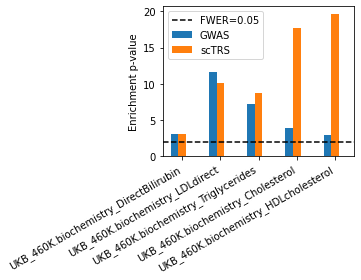

In [109]:
dic_config = {'gwas': ['C0', 'GWAS'], 
              'sctrs': ['C1', 'scTRS']}

df_plot = dic_stats[res][['GS']].copy()
for res in ['gwas', 'sctrs']:
    df_plot['%s.nlog10pval'%res] = -np.log10(dic_stats[res].loc[df_plot.index, 'pval'].values)
#     df_plot['%s.or'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio']
#     df_plot['%s.or_lb'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio.lb']
#     df_plot['%s.or_ub'%res] = dic_stats[res].loc[df_plot.index, 'odds_ratio.ub']
df_plot = df_plot.astype(dtype=float)
df_plot['loc'] = range(df_plot.shape[0])


plt.figure(figsize=[5, 4])
for i_res,res in enumerate(['gwas', 'sctrs']):
    mat_xerr = np
    plt.bar(df_plot['loc']+0.2*i_res-0.2, df_plot['%s.nlog10pval'%res],
            width=0.2, color=dic_config[res][0], label=dic_config[res][1])

fwer_thres = -np.log10(0.05/df_plot.shape[0])
plt.plot([-0.5, df_plot.shape[0]-0.5], [fwer_thres, fwer_thres], color='k', linestyle='--', 
         label='FWER=0.05')

plt.legend()
plt.xticks(df_plot['loc'], [x for x in df_plot.index], rotation=30, ha='right')
plt.ylabel('Enrichment p-value')
plt.xlim([-0.5, df_plot.shape[0]-0.5])
plt.tight_layout()
plt.savefig(FIG_PATH+'/comparison_gs.svg')
plt.show()